# The Strength Model
This code calculates the total yield strength for a aluminium alloy at different conditions using the Holmedal model. 
The code also includes the solid solution contribution and intrisinc contribution to the yield strength. 

The code is based on the following papers: 

B. Holmedal
https://doi.org/10.1080/09500839.2015.1125029

Feng Lu et al. 
https://doi.org/10.1016/j.msea.2021.142500

C. Hell et al.
https://doi.org/10.1016/j.actamat.2023.119095


In [115]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import matplotlib
from scipy.optimize import least_squares
from scipy.integrate import quad
from scipy import special
from typing import Dict
font = {'size'   : 22}
matplotlib.rc('font', **font)

### Load data

In [116]:
cu_path = "C://Users/espen/OneDrive - NTNU/semester 9/Project/Scripys/"
cu_free_path = r"D:/Universitet/cu_free/"
correction_path = r"D:/Universitet/Correction_values"
cond = ['2h','4h','10h','16h']
def load_data(file_path, cond, mode = 'Cu'):
    n = list()
    if mode == 'Cu':
        n_list = [4,7,3,10]
    elif mode == 'Cu_Free':
        n_list = [3,5,4,5]
    elif mode == 'Cu_L':
        n_list = [9,11,10,10]
    dict = {}
    index = 0
    for c in cond:
        data = []
        n = n_list[index]
        for i in range(1,n+1):
            if mode == 'Cu':
                f = open(file_path+f"{c}/_{i}.txt",'r')
            elif mode == 'Cu_Free':
                f = open(file_path+f"{c}/counting/length/_{i}.txt",'r')
            elif mode == 'Cu_L':
                f = open(file_path+f"{c}/L/_{i}.txt",'r')
            for line in f.readlines():
                if mode == 'Cu' or mode == 'Cu_L':
                    length = line
                    try:
                        if float(length) < 2:
                            continue
                    except Exception:
                        continue
                else:
                    length, box = line.split(';')
                    box = json.loads(box.strip())
                    if float(length) < 2 and np.max(box)>2048 or np.min(box)<0:
                        continue
                data.append(float(length))
        index += 1
        dict[c] = data
    return dict

# Load data from 22-045 (0.75 wt% Cu)
cu = load_data(cu_path, cond, 'Cu')
# Load data from L-phase 22-045 (0.75 wt% Cu)
cu_L = load_data(cu_path, cond, 'Cu_L')
# Load data from 22-042 (0.00 wt% Cu)
cu_free = load_data(cu_free_path, cond, 'Cu_Free')

# Strength model

In [119]:
class Holmedal():

    """
    Class that calculates the strength

    conditions : list - The times at which the strength is to be calculated
    data       : dict - The data contained in a dictionary in the format {condition: list of data}
    critical_cross_section : float - The chosen critical cross-section in nm^2
    mean_cross_section     : list  - The mean cross-section for each condition in nm^2
    density                : np.array - The density of precipitates for each conditions in #/nm^3
    volume_fraction        : list  - A list of the volumefraction for each condition
    alloy_composition      : Dict  - Composition of the alloy in format {Element : wt%}
    
    """
    def __init__(self, conditions : list, data: dict, critical_cross_section: float, mean_cross_section: list, density: np.array, volume_fraction: list, alloy_composition : Dict):
        self.conditions = conditions
        self.data       = data                
        self.a_c        = critical_cross_section # Critical cross-section (Usually found around peak hardness)
        self.a_m        = mean_cross_section     # Mean cross-section
        self.l_m        = []                     # Mean length
        self.l_c        = 0                      # Critical length
        self.rho        = density
        self.vf         = volume_fraction
        self.alloy      = alloy_composition      # Alloy composition in wt%
        self.alpha_p    = 0
    
        # Constants
        
        self.kappa      = 2
        self.M          = 2.7   # Taylor factor
        self.G          = 27E3  # [MPa] Shear modulus
        self.b          = 0.286 # [nm] Burgers vector

        # Strength values
        self.sigma_ss   = self.calculate_solid()
        self.sigma_0    = np.ones(len(self.conditions))*10 #MPa
        
        
        for condition in self.conditions:
            self.l_m.append(np.mean(self.data[condition]))
        self.l_m        = np.array(self.l_m)
        self.a_m        = np.array(self.a_m) 
        self.aspect_ratio = self.l_m/np.sqrt(self.a_m)
        self.aspect_ratio_parameters = self.fit_omega()
        
    def omega(self, x: list, l: float):
        """
        Graph of the form $a \cdot l^{b}$, to be fit to the aspect ratio points
        x: Paramteres to be fit (here list of 2 parameters)
        l: Precipitate length (can be array)
        """
        if type(l) == np.ndarray:
            arr =  x[0]*l**x[1]
            arr[arr<1] = 1
        else: 
            arr =  x[0]*l**x[1]
            if arr<1:
                arr = 1.0
        return arr
        
    def fit_omega(self):
        """
        Fit the aspect ratio to a function $\Omega(l) = a \cdot l^{b}$
        """
        x0_fit   = [0.7,0.7] #Starting values for fit
        residual = lambda x: self.aspect_ratio-self.omega(x,self.l_m)
        result   = least_squares(residual, x0_fit)
        return result.x

    def f(self,a):
        return np.min([(a/self.a_c)**2,1])
    
    def tau_p(self,alpha_p,G,b,f_bar):
        return alpha_p*G*b*np.sqrt(n_p)*f_bar**(3/2)*(1-1/6*f_bar**5)
        
    def phi_tilde(self, l : float, d1 : float, h : float):
        """
        Uncorrected distribution

        l  : The length at which you want to evaluate the distribution
        d1 : Precipitate length data used to fit the distribution
        h  : Calculated kernel bandwith for the data

        """
        return 1/len(d1)*sum(np.sqrt(2)*np.exp(-0.5*(([l]*len(d1)-d1)/h)**2)/((1+special.erf(d1/(np.sqrt(2)*h)))*h*np.sqrt(np.pi)))
        
    def phi(self, l : float, d1 : float, h : float):
        """
        Normalized precipitate length distribution. 

        A kernal density estimator with a Gaussian kernal to account for multi-modal distributions

        l  : The length at which you want to evaluate the distribution
        d1 : Precipitate length data used to fit the distribution
        h  : Calculated kernel bandwith for the data
        
        """
        
        return (self.phi_tilde(l,d1,h)-self.phi_tilde(0,d1,h)*np.exp(-0.5*(l/h)**2))/(1-0.5*h*np.sqrt(2*np.pi)*self.phi_tilde(0,d1,h))

    def calculated_kernel_bandwidth(self):
        """
        Returns kernel bandwidth, (h), corresponding to each condition. 

        The calculation is based on Scott's rule: $h \approx d N_l^{-0.2} \sigma_l$, where $\sigma_l$ is the standard deviation and d = 0.8. 
        
        """
        h_list = []
        for condition in self.conditions:
            data = self.data[condition]
            sigma= np.std(data)
            h    = 0.8*len(data)**(-0.2)*sigma
            h_list.append(h)
        return h_list
    
    def integrand1(self, l, data, h):
        """
        Shearable precipitate contribution
        """
        return l**(2*self.kappa+1)/self.omega(self.aspect_ratio_parameters,l)**(2*self.kappa)*self.phi(l,np.array(data),h)
    
    def integrand2(self,l, data, h):
        """
        Non-shearable precipitate contribution
        """
        return l*self.phi(l,np.array(data),h)

    def wt_2_at(self, u, cond):    
        """
        Convert wt% to at%
        """
        return self.alloy[cond]/u[cond] * (sum([self.alloy[k]/v for k,v in u.items()]))**(-1)

    def at_2_wt(self, sf,u , cond):
        """
        Convert at% to wt%
        """
        return sf*u[cond]/(sum([self.wt_2_at(u,k)*v for k, v in u.items()]))
    def calculate_solid(self):
        """
        Calculates the contribution from the alloying elements in solid solution, assuming all the precipitate are beta''

        """
        elements = ['Mg','Si','Cu']
        
        u_at = {'Al': 26.982, 'Mg': 24.305, 'Si': 28.085, 'Cu': 63.546, 'Fe': 55.845, 'Mn': 54.938, 'Cr': 51.996} # Atomic weights

        k    = {'Mg': 29.0, 'Si': 66.3, 'Cu': 46.4} #MPa

        betaDP = {'Mg': 0.42,'Si': 0.30, 'Cu': 0.03} #Average percentage of each element in beta'' 
        
        sf   = np.array(self.vf) * 22/24
        
        self.alloy['Al'] = 100-sum([v for k, v in self.alloy.items()])
        self.alloy['Si'] = 0.95
        
        sf_mg = (0.42*sf)
        sf_cu = (0.03*sf)
        sf_si = (0.30*sf)
        # wt% of alloying elements in solid solution
        wt_mg = self.alloy['Mg'] - self.at_2_wt(sf_mg,u_at,'Mg')
        wt_si = self.alloy['Si'] - self.at_2_wt(sf_mg,u_at,'Si')
        wt_cu = self.alloy['Cu'] - self.at_2_wt(sf_cu,u_at,'Cu')
        wt_cu = np.array([max([0,i]) for i in wt_cu]) #Make sure Cu-content not unphysical
        return k['Mg']*wt_mg**(2/3) + k['Si']*wt_mg**(2/3)+ k['Cu']*wt_mg**(2/3)

        
    def calculate_strength(self, calibration_point: dict):
        """
        Calculates the yield strength (shear stress) due to precipitates. 

        calibration_point: a dictionary containing the calibration condition and experimental vickers hardness in that condition in the form {'condition' : strength}

        Returns the calibrated Vickers hardness using Yield strength = 3 * HV
        
        """
        
        residual = lambda l: np.sqrt(self.a_c)*self.omega(self.aspect_ratio_parameters,l)-l
        self.l_c      = least_squares(residual, 16).x[0] #Critial length
        kernel_bandwidths = self.calculated_kernel_bandwidth()
        
        sigma_p  = []
        for index, condition in enumerate(self.data):
            data = self.data[condition]
            h = kernel_bandwidths[index]
            f_bar = (quad(self.integrand1, 0, self.l_c, args = (data, h))[0]/(self.a_c**self.kappa)+ quad(self.integrand2, self.l_c, 1000, args = (data, h))[0])/(self.l_m[index]) # Mean obstacle strength
            
            n_p = np.sqrt(3)/3*self.l_m[index]*self.rho[index] #Number density of precipitate-based obstacles per slip plane
            sigma_p.append(self.M*self.G*self.b*np.sqrt(n_p)*f_bar**(3/2)*(1-1/6*f_bar**5))
        sigma_p  = np.array(sigma_p)
        condition =  list(calibration_point.keys())[0]
        index = list(self.data.keys()).index(condition)
        if calibration_point[condition]<1: #Calibration constant is alpha_p
            self.alpha_p = calibration_point[condition]
        else: #Calibration constant is strength in HV
            self.alpha_p = ((calibration_point[condition]-16)*3-self.sigma_ss[index]-self.sigma_0[index])/sigma_p[index]
        return (np.array(sigma_p)*self.alpha_p + self.sigma_ss + self.sigma_0)/3 + 16


model_cu = Holmedal(conditions             = cond,
                    data                   = cu,
                    critical_cross_section = 5.5,
                    mean_cross_section     = [5.2,5.5,6.6,8],
                    density                = np.array([11.8,14.8,6.7,5.7])*1E-5,
                    volume_fraction        = [1.11,1.7,1.14,1.62],
                    alloy_composition      = {'Mg': 0.61, 'Si': 1.11, 'Cu': 0.77, 'Fe':0.20,'Mn': 0.57, 'Cr':0.13})

# model_cu_L = Holmedal(conditions             = cond,
#                       data                   = cu_L,
#                       critical_cross_section = 5.5,
#                       mean_cross_section     = [3.3,4.3,6.7,8.7],
#                       density                = np.array([1.5,3.4,3.7,4.3])*1E-6,
#                       volume_fraction        = [0.02,0.06,0.15,0.25],
#                       alloy_composition      = {'Mg': 0.61, 'Si': 1.11, 'Cu': 0.77, 'Fe':0.20,'Mn': 0.57, 'Cr':0.13})

model_cu_free = Holmedal(conditions             = cond, 
                         data                   = cu_free, 
                         critical_cross_section = 10.3, 
                         mean_cross_section     = [10.4,9.9,12.7,13.4], 
                         density                = np.array([3.2,3.8,2.5,2.22])*1E-5, 
                         volume_fraction        = [1.33,1.47,1.48,1.54], 
                         alloy_composition      = {'Mg': 0.60, 'Si': 1.1, 'Cu': 0, 'Fe':0.19,'Mn': 0.57, 'Cr':0.13})

# model_cu_free = Holmedal(conditions             = cond[1:], 
#                          data                   = {k : cu_free[k] for k in cond[1:]}, 
#                          critical_cross_section = 5.5, 
#                          mean_cross_section     = [9.9,12.7,13.4], 
#                          density                = np.array([3.8,2.5,2.22])*1E-5, 
#                          volume_fraction        = [1.47,1.48,1.54], 
#                          alloy_composition      = {'Mg': 0.60, 'Si': 1.1, 'Cu': 0, 'Fe':0.19,'Mn': 0.57, 'Cr':0.13})

## Calculate and calibrate strength

In [120]:
strength_cu = model_cu.calculate_strength({'4h':131.6667})
strength_cu_free = model_cu_free.calculate_strength({'4h':105.3})

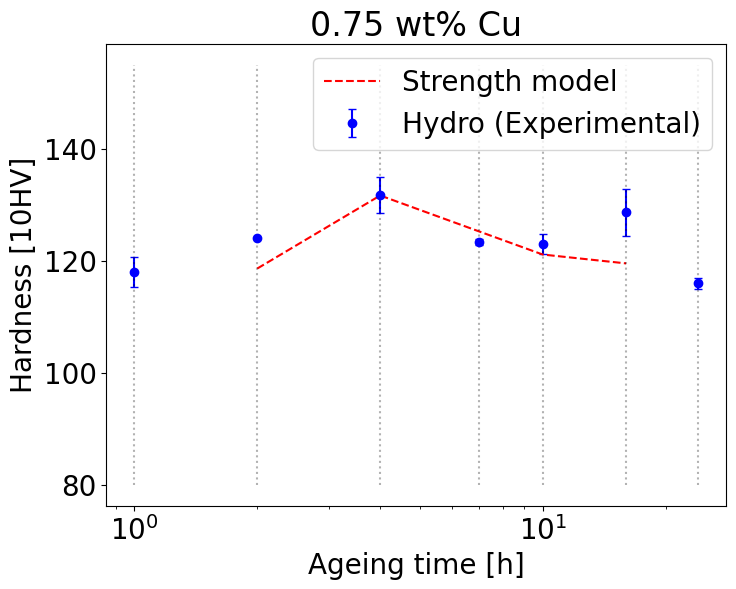

In [121]:
font = {'size'   : 20}
matplotlib.rc('font', **font)
fig, ax = plt.subplots(figsize = (8,6))
x2 = np.array([1,2,4,7,10,16,24])
x3 = np.array([2,4,10,16])
res_hydro = [118,124,131.6667,123.3333, 123, 128.6667, 116]
std_hydro = [2.645751,0,3.21455,0.57735,1.752051, 4.163332,1]
ax.errorbar(x2,res_hydro,yerr = std_hydro, fmt='o', color = 'b', label = 'Hydro (Experimental)', alpha = 1,capsize = 3)
ax.plot(x3,strength_cu,'r--', label = 'Strength model')
for i in x2:
    ax.vlines(i, 80,155,color = 'black', ls = ':', alpha = 0.3)
# ax.set_ylim([80,155])
ax.set_ylabel(r'Hardness [10HV]')
ax.set_xlabel('Ageing time [h]')
ax.set_xscale('log')
ax.set_title('0.75 wt% Cu')
ax.legend()
plt.savefig(r"ModelCu.png", dpi = 300, bbox_inches = 'tight')

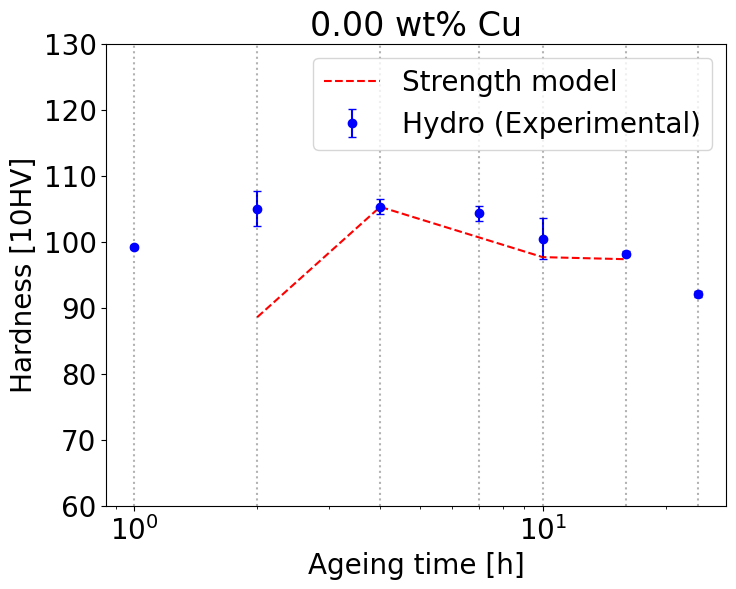

In [123]:
fig, ax = plt.subplots(figsize = (8,6))
x2 = np.array([1,2,4,7,10,16,24])
x3 = np.array([2,4,10,16])
# x3 = np.array([4,10,16])
res_hydro = [99.2,105,105.3,104.3,100.5,98.2,92.1]
std_hydro = [0.351188, 2.645751, 1.154701, 	1.154701, 3.13422, 0.4, 0.503322]
ax.errorbar(x2,res_hydro,yerr = std_hydro, fmt='o', color = 'b', label = 'Hydro (Experimental)', alpha = 1,capsize = 3)
ax.plot(x3,strength_cu_free,'r--', label = 'Strength model')
for i in x2:
    ax.vlines(i, 60,155,color = 'black', ls = ':', alpha = 0.3)
ax.set_ylim([60,130])
ax.set_ylabel(r'Hardness [10HV]')
ax.set_xlabel('Ageing time [h]')
ax.set_xscale('log')
ax.set_title('0.00 wt% Cu')
ax.legend()
plt.savefig(r"ModelCuFree2.png", dpi = 300, bbox_inches = 'tight')

## Plot aspect ratio

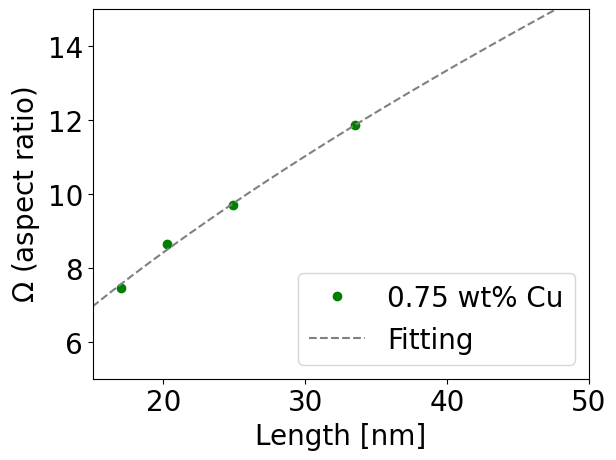

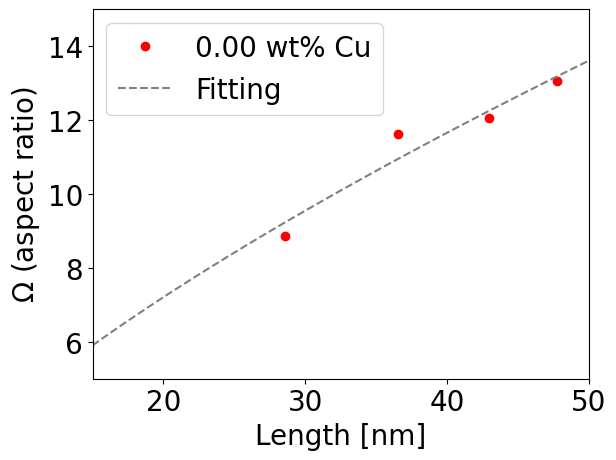

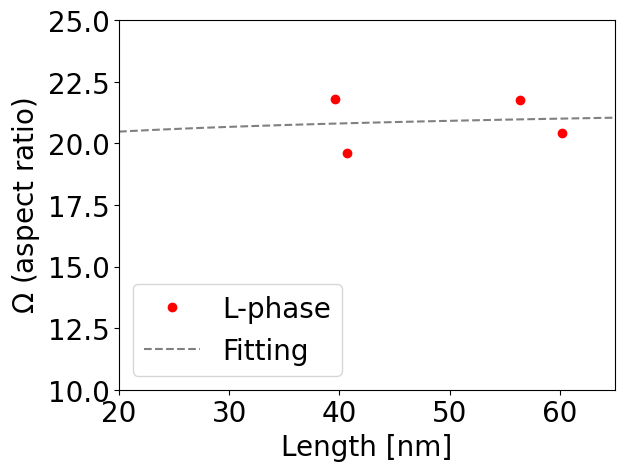

In [124]:
x = np.linspace(15,150,100)
fig, ax = plt.subplots()
ax.plot(model_cu.l_m, model_cu.aspect_ratio,'go', label = '0.75 wt% Cu')
ax.plot(x, model_cu.omega(model_cu.aspect_ratio_parameters,x),ls = '--',color = 'grey', label = 'Fitting')
ax.set_ylabel(r'$\Omega$ (aspect ratio)')
ax.set_xlabel('Length [nm]')
ax.set_xlim([15,50])
ax.set_ylim([5,15])
ax.legend()
plt.savefig(r"omegaCu.png", dpi = 300, bbox_inches = 'tight')
fig, ax = plt.subplots()
ax.plot(model_cu_free.l_m, model_cu_free.aspect_ratio,'ro', label = '0.00 wt% Cu')
ax.plot(x, model_cu_free.omega(model_cu_free.aspect_ratio_parameters,x),ls = '--',color = 'grey', label = 'Fitting')
ax.set_ylabel(r'$\Omega$ (aspect ratio)')
ax.set_xlabel('Length [nm]')
ax.set_xlim([15,50])
ax.set_ylim([5,15])
ax.legend()
plt.savefig(r"omegaFree.png", dpi = 300, bbox_inches = 'tight')
fig, ax = plt.subplots()
ax.plot(model_cu_L.l_m, model_cu_L.aspect_ratio,'ro', label = 'L-phase')
ax.plot(x, model_cu_L.omega(model_cu_L.aspect_ratio_parameters,x),ls = '--',color = 'grey', label = 'Fitting')
ax.set_ylabel(r'$\Omega$ (aspect ratio)')
ax.set_xlabel('Length [nm]')
ax.set_xlim([20,65])
ax.set_ylim([10,25])
ax.legend()
plt.savefig(r"omegaL.png", dpi = 300, bbox_inches = 'tight')

## Plot Distribution:

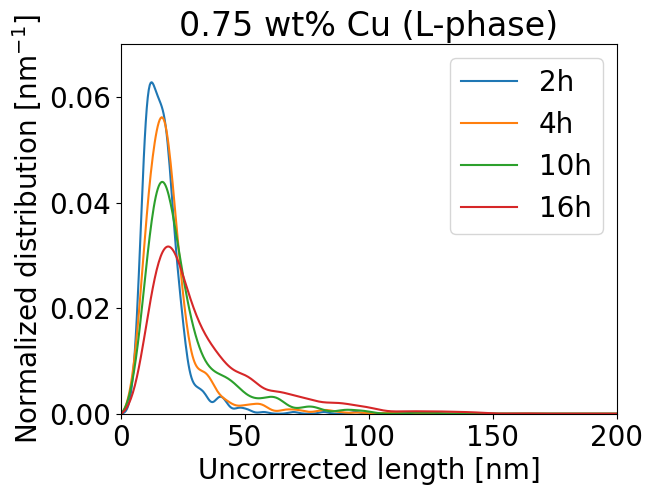

In [125]:
fig, ax = plt.subplots()
l = np.linspace(0,200,500)

model = model_cu
data_dict = model.data
h_list    = model.calculated_kernel_bandwidth()
for index, cond in enumerate(data_dict):
    data = np.array(data_dict[cond])
    h    = h_list[index]
    ax.plot(l,[model.phi(i,data,h) for i in l], label = cond)
ax.legend()
ax.set_xlim([0,200])
ax.set_ylim([0,0.07])
ax.set_ylabel('Normalized distribution [nm$^{-1}$]')
ax.set_xlabel('Uncorrected length [nm]')
ax.set_title('0.75 wt% Cu (L-phase)')
plt.savefig(r"distCu2.png", dpi = 300, bbox_inches = 'tight')